# Convolutional AE using NLPD in Keras

In [ ]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [ ]:
# PERCEPTUAL METRIC
!pip install https://github.com/google-research/perceptual-quality/archive/master.zip

from perceptual_quality import nlpd


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/google-research/perceptual-quality/archive/master.zip


In [ ]:
# DATA, CIFAR10
from keras.datasets import cifar10
import numpy as np

(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
                                   

In [ ]:
# MODEL

# ENCODER
input_img = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))  
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#encoded = MaxPooling2D((2, 2), padding='same',activity_regularizer=regularizers.l1(10e-5))(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# DECODER
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2),interpolation='bilinear')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2),interpolation='bilinear')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2),interpolation='bilinear')(x)
decoded = Conv2D(x_train.shape[3], (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)


In [ ]:
# Defining a loss function to do the mean over samples and channels
# I guess is not needed but...

import keras.backend as K

def loss_nlpd(y_true,y_pred):

    return K.mean(nlpd.nlpd_fast(y_true, y_pred,3,))

In [ ]:
# PERCEPTUAL METRIC TEST

import tensorflow as tf
x_train_tf = tf.image.resize(x_train[0:100,:,:,:],(x_train.shape[1]*1,x_train.shape[2]*1))

res =loss_nlpd(x_train_tf[0:10,:,:,:],x_train_tf[0:10,:,:,:])

res.numpy()

0.0

In [ ]:
# MODEL COMPILATION

opt = Adam(learning_rate=0.001)
# To use it as loss function
autoencoder.compile(opt,loss=loss_nlpd)
# To use it as metric
# autoencoder.compile(opt,loss='MSE',metrics=loss_nlpd)

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 8)           1160  

In [ ]:
# TRAINING
hist = autoencoder.fit(x_train, x_train,
                epochs=10,
                batch_size=128,
                shuffle=True, validation_split=0.1)

Epoch 1/10
352/352 [==============================] - 11s 20ms/step - loss: 0.1614 - val_loss: 0.1499
Epoch 2/10
352/352 [==============================] - 6s 17ms/step - loss: 0.1484 - val_loss: 0.1478
Epoch 3/10
352/352 [==============================] - 6s 17ms/step - loss: 0.1452 - val_loss: 0.1433
Epoch 4/10
352/352 [==============================] - 5s 15ms/step - loss: 0.1430 - val_loss: 0.1414
Epoch 5/10
352/352 [==============================] - 4s 12ms/step - loss: 0.1415 - val_loss: 0.1405
Epoch 6/10
352/352 [==============================] - 4s 12ms/step - loss: 0.1402 - val_loss: 0.1392
Epoch 7/10
352/352 [==============================] - 4s 12ms/step - loss: 0.1392 - val_loss: 0.1391
Epoch 8/10
352/352 [==============================] - 4s 11ms/step - loss: 0.1383 - val_loss: 0.1378
Epoch 9/10
352/352 [==============================] - 4s 12ms/step - loss: 0.1376 - val_loss: 0.1364
Epoch 10/10
352/352 [==============================] - 4s 11ms/step - loss: 0.1368 - val_l

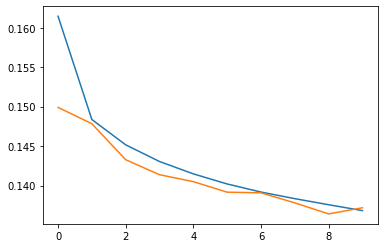

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])


In [ ]:
# TEST
decoded_imgs = autoencoder.predict(x_test)

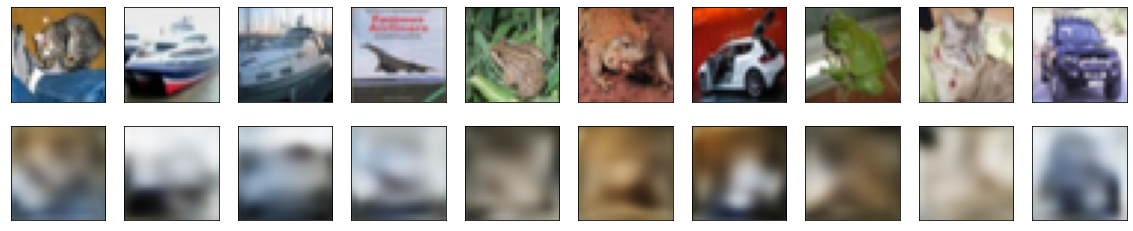

In [ ]:
import matplotlib.pyplot as plt

n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruccion
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()